# SYDE 675 --- Assignment 1
**Student ID: 21095594**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [ ]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 3. Programming

## 3.1 Overcoming a Prior

As we covered in class, the Beta distribution is the conjugate prior to a Bernoulli distribution.  Here we will generate observations from $n$ coin flips from an unfair coin with probability of a heads as $P(H=1) = p$, where the true value is $p=0.3$.

In [ ]:
def flip_coin(p=0.3, num_flips=1):
    return (np.random.uniform(low=0,high=1,size=(num_flips,)) < p).astype(int)

In [ ]:
a = flip_coin(p=0.3, num_flips=100)
a

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

We will compute a posterior distribution for $p$ by updating a Beta distribution using observations from the above ```flip_coin``` function.  To illustrate the effect a prior can have, we will compute the posterior distribution using a "good", "bad", and "uninformative" set of parameters, the "pseudocounts" discussed in class.

| Condition | $a$ | $b$ |
|:--- |:---:|:---:|
| Good | 1 | 2 |
| Bad | 10 | 1 |
| Uninformative | 1 | 1 |

Below we show how to evaluate the PDF of a Beta distribution given parameters $a$ and $b$.

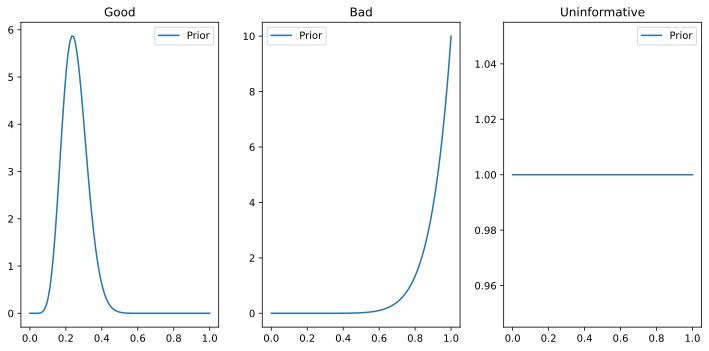

In [ ]:
good_condition = {'a':10,'b':30}
bad_condition = {'a':10,'b':1}
uninformative_condition = {'a':1,'b':1}

ps = np.linspace(0,1,100)

cond_names = ['Good','Bad','Uninformative']
plt.figure(figsize=(10,5))
for cond_idx, condition in enumerate([good_condition, bad_condition, uninformative_condition]):
    plt.subplot(1,3,1+cond_idx)

    beta_rv = beta(a=condition['a'],b=condition['b'])
    plt.plot(ps, beta_rv.pdf(ps), label='Prior')
    plt.title(cond_names[cond_idx])

    plt.legend()

plt.tight_layout()

Your task is to

1. Compute and plot the posterior distribution over $p$ for each condition, for $n \in \{10,100,1000,10000\}$.
2. For each condition, plot the error in the MAP estimate of $p$ as a function of $n$.

Hints:

1. The Beta distribution is the conjugate prior for the Bernoulli distribution.
1. The MAP estimate will be the value of $p \in [0,1]$ for which the posterior PDF takes on a maximum value.  
2. For the purposes of this assigment, you can approximate the MAP estimate by finely sampling the domain $[0,1]$, say 100 sample points, _i.e._, ```ps = np.linspace(0,1,100)```.

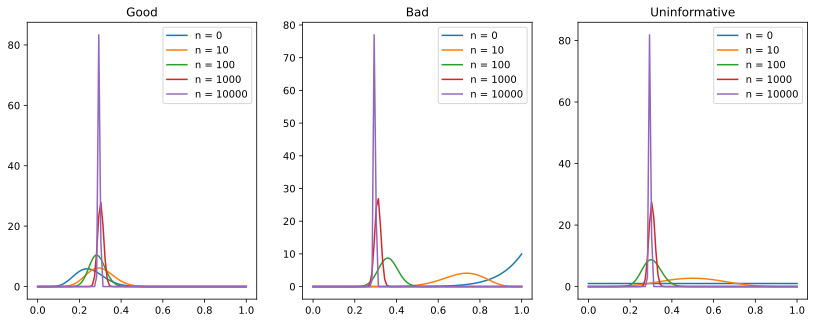

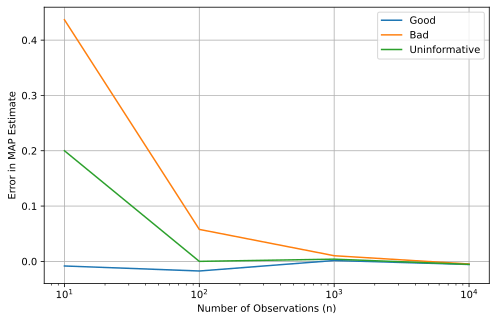

<Figure size 640x480 with 0 Axes>

In [ ]:
# ✍ \<YOUR SOLUTION HERE\>
good_condition = {'a':10,'b':30}
bad_condition = {'a':10,'b':1}
uninformative_condition = {'a':1,'b':1}

ps = np.linspace(0,1,100)

cond_names = ['Good','Bad','Uninformative']
plt.figure(figsize=(14,5))
flips = [0,10,100,1000,10000]

# define two empty arrays to store the number of heads and tails after each trial
heads = np.empty(5)
tails = np.empty(5)

# define a dictionary to store errors of MAP estimate
errors = {
    'Good': [],
    'Bad': [],
    'Uninformative': []
}

for i in range(5):
    heads[i] = sum(flip_coin(p=0.3, num_flips=flips[i]))
    tails[i] = flips[i] - heads[i]

# plot task 1
for cond_idx, condition in enumerate([good_condition, bad_condition, uninformative_condition]):
    for i in range(5):

        plt.subplot(1,3,1+cond_idx)
        posterior_a = condition['a'] + heads[i]
        posterior_b = condition['b'] + tails[i]
        beta_rv = beta(a=posterior_a,b=posterior_b)
        #beta_rv = beta(a=condition['a']+heads[i],b=condition['b']+tails[i])

        plt.plot(ps, beta_rv.pdf(ps), label=f'n = {flips[i]}')
        plt.title(cond_names[cond_idx])
        plt.legend()

        if i>0:
            map_estimate = (posterior_a - 1) / (posterior_a + posterior_b - 2)
            error = map_estimate - 0.3
            errors[cond_names[cond_idx]].append(error)

# plot task 2
plt.figure(figsize=(8, 5))
for condition, error_values in errors.items():
    plt.plot(flips[1:5], error_values, label=condition)

plt.xscale('log')
plt.xlabel('Number of Observations (n)')
plt.ylabel('Error in MAP Estimate')
plt.legend()
plt.grid(True)
plt.show()

plt.tight_layout()

## 3.2 Classification with a Kernel Density Estimator.

Here we will use the Scikit-Learn kernel density estimator to construct a Bayesian classifier.  We will test it using the two moons data set.  

Remember that given a dataset of observations $S = ((x_{1},y_{1}),\ldots,(x_{m},y_{m}))$ and a kernel density estimator $p(x\mid (x_{1},\ldots,x_{m}))$, we can construct our Bayesian classifier using the following elements:


1. The likelihood is approximated: $p(x \mid C = c) = p(x \mid \{x_{i} \in S\mid_{x} : y_{i} = c\})$.  
1. The marginal distribution for $x$ is approximated: $p(x) = p(x \mid S\mid_{x})$,
1. The prior is approximated $p(C=c) = \frac{|\{y_{i} \in S\mid_{y} : y_{i} = c\}|}{|S\mid_{y}|}$,  Note that we can implement this with a simple histogram with 2 bins for a binary classification.

Let us generate some data points.

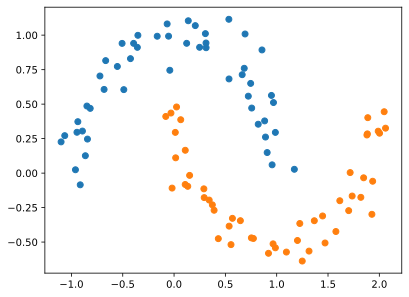

In [ ]:
num_training_samples = 100
num_testing_samples = 100

colors = ['tab:blue','tab:orange']


from sklearn.datasets import make_moons

np.random.seed(0)
X_train, y_train = make_moons(n_samples=num_training_samples, noise=0.1)
X_test, y_test = make_moons(n_samples=num_testing_samples, noise=0.1)


plt.scatter(X_train[:,0], X_train[:,1],color=[colors[y.astype(int)] for y in y_train])

Now we need to fit a kernel density estimator.  We will use SciKit Learn's Kernel Density Estimator to fit the training data.  We will use a Gaussian kernel. We will modify the _length scale_ or _bandwidth_ parameter to change the performance of the classifier.

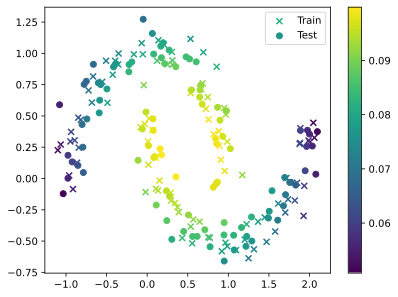

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_train)

prob_train = np.exp(kde.score_samples(X_train))
prob_test = np.exp(kde.score_samples(X_test))
plt.scatter(X_train[:,0], X_train[:,1], marker='x', c=prob_train, label='Train')
plt.scatter(X_test[:,0], X_test[:,1], marker='o', c=prob_test, label='Test')
plt.colorbar()
plt.legend()

Note that in the above, we computed the probability the samples using the statement ```np.exp(kde.score_samples(X_train))```.
We exponentiate the ```score_samples``` function because it returns the log probability, as opposed to just the probability.

Next you will construct the classifier using a kernel density estimator for the whole data set (as constructed above), one just for class 0 samples, and another just for class 1 samples.



In [ ]:
def classification_error(y_true, y_pred):
    return np.mean(y_true != y_pred)

def classifier(x_test, kde_0, kde_1, kde_marginal, prior):
    likelihood_0 = np.exp(kde_0.score_samples(x_test)) # your code here p(x | D_0)
    likelihood_1 = np.exp(kde_1.score_samples(x_test)) # your code here p(x | D_1)
    marginal_prob = np.exp(kde_marginal.score_samples(x_test)) # p(x | D)

    posterior_0 = likelihood_0 * prior[0]/marginal_prob # p(C=0|x) = p(x|C=0)p(C=0)/p(x)
    posterior_1 = likelihood_1 * prior[1]/marginal_prob # p(C=1|x) = p(x|C=1)p(C=1)/p(x)

    return np.argmax([posterior_0, posterior_1], axis=0)

In [ ]:

# X_train_0 = X_train[y_train == 0]
# X_train_1 = X_train[y_train == 1]

# kde_0_001 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X_train_0)
# kde_1_001 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X_train_1)
# kde_marginal_001 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X_train)
# prior_001 = np.histogram(y_train, bins=2)[0] / len(y_train)

You will compute the testing and training classification error, which is the classification performance on the testing and training sets using KDEs that are fit using only the training data set.

Below you will plot the classification error, which you can compute using the ```sklearn.metrics.zero_one_loss``` function.  Plot the classification errors as a function of the kernel bandwidth, testing values of $h \in \{0.01,0.1,1,10,100\}$.  Use the same kernel bandwidth for all three estimators.

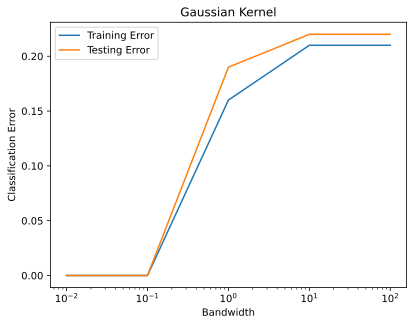

In [ ]:
# ✍ \<YOUR SOLUTION HERE\>
from sklearn.metrics import zero_one_loss

# define variables to store errors
train_errors = []
test_errors = []

bandwidths = [0.01, 0.1, 1, 10, 100]

for bandwidth in bandwidths:

    kde_0 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train[y_train == 0])
    kde_1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train[y_train == 1])
    kde_marginal = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train)

    prior = np.histogram(y_train, bins=2)[0] / len(y_train)

    y_train_pred = classifier(X_train, kde_0, kde_1, kde_marginal, prior)
    y_test_pred = classifier(X_test, kde_0, kde_1, kde_marginal, prior)

    train_error = zero_one_loss(y_train, y_train_pred)
    test_error = zero_one_loss(y_test, y_test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

# plot the errors
plt.plot(bandwidths, train_errors, label='Training Error')
plt.plot(bandwidths, test_errors, label='Testing Error')
plt.xscale('log')
plt.xlabel('Bandwidth')
plt.ylabel('Classification Error')
plt.title('Gaussian Kernel')
plt.legend()
plt.show()

Repeat the above process for a Top Hat kernel with $n=100$ training sample points.

<ipython-input-15-18a5c9b52ba8>:9: RuntimeWarning: invalid value encountered in divide
  posterior_0 = likelihood_0 * prior[0]/marginal_prob # p(C=0|x) = p(x|C=0)p(C=0)/p(x)
<ipython-input-15-18a5c9b52ba8>:10: RuntimeWarning: invalid value encountered in divide
  posterior_1 = likelihood_1 * prior[1]/marginal_prob # p(C=1|x) = p(x|C=1)p(C=1)/p(x)
<ipython-input-15-18a5c9b52ba8>:9: RuntimeWarning: invalid value encountered in divide
  posterior_0 = likelihood_0 * prior[0]/marginal_prob # p(C=0|x) = p(x|C=0)p(C=0)/p(x)
<ipython-input-15-18a5c9b52ba8>:10: RuntimeWarning: invalid value encountered in divide
  posterior_1 = likelihood_1 * prior[1]/marginal_prob # p(C=1|x) = p(x|C=1)p(C=1)/p(x)


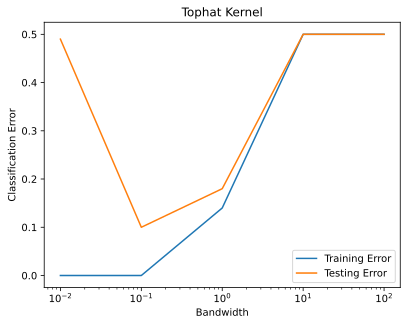

In [ ]:
# ✍ \<YOUR SOLUTION HERE\>
train_errors_tophat = []
test_errors_tophat = []


# change kernel
for bandwidth in bandwidths:
    kde_0 = KernelDensity(kernel='tophat', bandwidth=bandwidth).fit(X_train[y_train == 0])
    kde_1 = KernelDensity(kernel='tophat', bandwidth=bandwidth).fit(X_train[y_train == 1])
    kde_marginal = KernelDensity(kernel='tophat', bandwidth=bandwidth).fit(X_train)

    prior = np.histogram(y_train, bins=2)[0] / len(y_train)

    y_train_pred = classifier(X_train, kde_0, kde_1, kde_marginal, prior)
    y_test_pred = classifier(X_test, kde_0, kde_1, kde_marginal, prior)

    train_error = zero_one_loss(y_train, y_train_pred)
    test_error = zero_one_loss(y_test, y_test_pred)

    train_errors_tophat.append(train_error)
    test_errors_tophat.append(test_error)

# plot the errors
plt.plot(bandwidths, train_errors_tophat, label='Training Error')
plt.plot(bandwidths, test_errors_tophat, label='Testing Error')
plt.xscale('log')
plt.xlabel('Bandwidth')
plt.ylabel('Classification Error')
plt.title('Tophat Kernel')
plt.legend()
plt.show()

Repeat the process for a Gaussian kernel with $n=400$ training sample points.

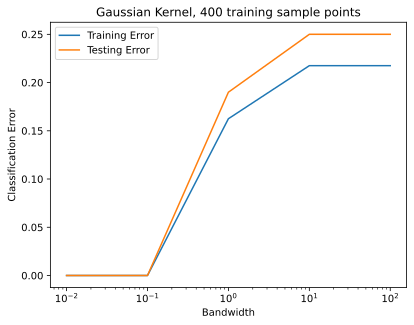

In [ ]:
# ✍ \<YOUR SOLUTION HERE\>
# change training sample size
num_training_samples = 400
num_testing_samples = 100

np.random.seed(0)
X_train, y_train = make_moons(n_samples=num_training_samples, noise=0.1)
X_test, y_test = make_moons(n_samples=num_testing_samples, noise=0.1)

train_errors_400 = []
test_errors_400 = []
# bandwidths = [0.01, 0.1, 1, 10, 100]

for bandwidth in bandwidths:
    kde_0 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train[y_train == 0])
    kde_1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train[y_train == 1])
    kde_marginal = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train)
    prior = np.histogram(y_train, bins=2)[0] / len(y_train)

    y_train_pred = classifier(X_train, kde_0, kde_1, kde_marginal, prior)
    y_test_pred = classifier(X_test, kde_0, kde_1, kde_marginal, prior)

    train_error = zero_one_loss(y_train, y_train_pred)
    test_error = zero_one_loss(y_test, y_test_pred)

    train_errors_400.append(train_error)
    test_errors_400.append(test_error)

# plot the errors
plt.plot(bandwidths, train_errors_400, label='Training Error')
plt.plot(bandwidths, test_errors_400, label='Testing Error')
plt.xscale('log')
plt.xlabel('Bandwidth')
plt.ylabel('Classification Error')
plt.title('Gaussian Kernel, 400 training sample points')
plt.legend()
plt.show()